<p><a href="https://colab.research.google.com/github/compgeog/choropleth-tradeoffs/blob/main/explore_choropleth.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a></p>

# Exploring Classification Tradeoffs for Choropleth Maps


The following two cells contain commands that are used to install necessary libraries. They do not need to be run every time. They are commented out. 

In [ ]:
!git clone git@github.com:gisalgs/geom.git 
!git clone git@github.com:gisalgs/spatialanalysis.git 

In [ ]:
!pip install ray
!pip install matplotlib

The following two cells make sure the necessary libraries and modules are imported to run the experiments in the rest of this notebook.

In [1]:
from geom.shapex import *
from spatialanalysis.moransi2 import *
from util.get_adjacency_matrix import *
from util.draw_polygons_shapex import *
from util.get_attribute_by_name import *
from util.evaluate_all import *
from util.pareto_ranking import *
from util.parallel_coordinates import *
from util.xcolorbrewer import *
from util.breakpoints2 import *

In [2]:
import ray
import time
import random
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

from os import cpu_count

In [3]:
shpfname = 'data/il/il.shp'
attrname = 'FARM_PROD'

shp = shapex(shpfname)

adjacency_list = adjacency_matrix(shp, output='L')

all_values = get_shp_attribute_by_name(shp, attrname)
all_areas = get_shp_attribute_by_name(shp, 'AREA')

numclass = 5

m = len(all_values) # number of data

Get the unique values:

In [4]:
unique_values = list(set(all_values))
unique_values.sort()
n = len(unique_values)
print(n, m, min(unique_values), max(unique_values))

101 102 15.57 155.3


In [5]:
shp.bounds

(115181.34624100267, 4095659.5064726495, 455924.96284696716, 4712750.858482279)

In [6]:
shp[0]['properties'][attrname]

50.12

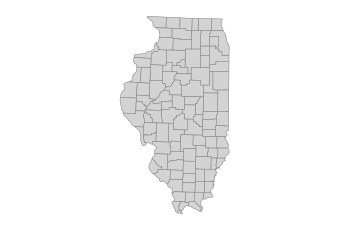

In [7]:
draw_shape(shp)
plt.axis('off')
plt.axis('equal')
plt.show()

Now we generate all the break points. A Python iterator is implemented (in `breakpoints2.py`) to yield every sequential unique and non-repeating combination of the elements provided (such as a list of numbers) for a given length. [This stackoverlow page](http://stackoverflow.com/questions/127704/algorithm-to-return-all-combinations-of-k-elements-from-n) has some excellent sources for this type of algorithms. We call the `choose` function to get a list of all such combinations. For example, the following will return all the combinations of 2 numbers from a list [1, 2, 3].

In [8]:
choose([1, 2, 3], 2)

[(1, 2), (1, 3), (2, 3)]

And we can also find the combinations from a string of characters.

In [9]:
choose('foxy', 3)

[('f', 'o', 'x'), ('f', 'o', 'y'), ('f', 'x', 'y'), ('o', 'x', 'y')]

For our data, we want to find the break points -- the positions where we can break the original, sorted data into a number of classes. If we have 10 numbers, there will be up to 9 break points. To create `numclass` classes, we will `numclass-1` break points.

In [10]:
all_brks = choose(range(n-1), numclass-1)

It is not a good idea to print them out, because there are really a lot (millions):

In [11]:
len(all_brks)

3921225

Instead, we will just look at some (one) randomly:

In [12]:
i = random.randint(0, len(all_brks)-1)
print('Break point', i+1, 'is', all_brks[i])

Break point 2572749 is (23, 25, 62, 88)


Now we get the actual intervals using the above random break points. Must use unique values.

In [13]:
intervals = Intervals()
brks = all_brks[i]

intervals.set_classes_by_data2(list(brks), unique_values)
intervals

[15.57 - 34.63], [36.24 - 37.57], [38.22 - 58.5], [59.65 - 84.84], [85.41 - 155.3]

Intervals can also be set given a set of bounds:

In [14]:
new_intervals = Intervals()
new_bounds = [ [15.57, 41.20], [41.21, 60.66], [60.67, 77.29], [77.30, 100.10], [100.10, 155.30] ]
new_intervals.set_classes(new_bounds)
new_intervals

[15.57 - 41.2], [41.21 - 60.66], [60.67 - 77.29], [77.3 - 100.1], [100.1 - 155.3]

## Using break points to draw a map

We first calculate the bounds of the map, which will be used later.

In [15]:
xmin, xmax = int(shp.bounds[0])-1, int(shp.bounds[2])+1
ymin, ymax = int(shp.bounds[1]-1), int(shp.bounds[3]+1)

We draw the map using the intervals stored in `intervals`:

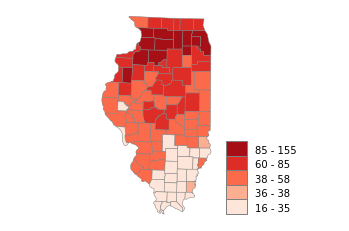

In [18]:
# get the classes using the break points in intervals
classes = [intervals.get_class(v) for v in all_values]

# get the color scheme
colors = get_colorbrewer_specs('Reds', numclass)

# set up the canvas (ax0 is used in rect_legend)
_, ax0 = plt.subplots()

draw_shape(shp, classes, colors)

box_w = (xmax-xmin)/5  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax0, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals)

plt.axis('off')
plt.axis('equal')
plt.show()


## Evaluating intervals

We can get the class assignment of each value in the data:

In [20]:
classes = [intervals.get_class(v) for v in all_values]

In [21]:
gvf2(classes, all_values, numclass)

0.8656400444457593

In [22]:
oai(classes, all_values, all_areas, numclass)

0.6015479851555836

In [23]:
class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
class_means = [ sum([all_values[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
                for j in range(numclass) ]
means = [ class_means[i] for i in classes ]
moransi2(means, adjacency_list)

0.7649504696340123

In [24]:
bai(adjacency_list, all_values, classes)

0.6639871484318176

Now we write two functions to wrap the code so we can use them repeatedly later. We assume the following variables available:

-  `all_values`
-  `unique_values`
-  `all_areas`
-  `numclass`

In [28]:
# given a set of intervals, returns a tuple of the four criteria values: GVF, OAI, Moran's I, BAI 
def eval_intervals(_intervals):
    classes = [_intervals.get_class(i) for i in all_values]
    class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
    class_means = [ sum([all_values[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
                    for j in range(numclass) ]
    means = [ class_means[i] for i in classes ]
    o1 = gvf2(classes, all_values, numclass)
    o2 = oai(classes, all_values, all_areas, numclass)
    o3 = moransi2(means, adjacency_list)
    o4 = bai(adjacency_list, all_values, classes)
    return o1, o2, o3, o4

# given a set of break points, returns a tuple that contains the intervals and a tuple of the four criteria values
def eval_break_points(break_points):
    intervals = Intervals()
    intervals.set_classes_by_data2(list(break_points), unique_values)
    return intervals, eval_intervals(intervals)

In [29]:
eval_break_points(brks)

([15.57 - 34.63], [36.24 - 37.57], [38.22 - 58.5], [59.65 - 84.84], [85.41 - 155.3],
 (0.8656400444457593,
  0.6015479851555836,
  0.7649504696340123,
  0.6639871484318176))

## Evaluating all intervals

This part is where the major computation goes. There is no need to re-run this part because we can save the results from the computation and only use the result files in the later parts of this tutorial. We can either run the computation in parallel using the code immediately below, or run sequentially (which will take longer time).

To run in parallel, we distribute the tasks to each of the CPUs (cores). The following code creates a list called `break_inputs` that holds the break points to be distributed to each CPU:

In [30]:
# It is possible to just run for a subset of the breaks for a quick experiment. To do so, we can sample a subset and then replace all_brks to sub_brks below.

# subset_size = 50000
# sub_brks = random.sample(all_brks, subset_size)
# n = len(sub_brks)

num_proc = cpu_count()
n = len(all_brks)

num_to_proc = n//num_proc
ranges = [num_to_proc for _ in range(num_proc)]
ranges[-1] += n - sum(ranges)

# sub_brks = random.sample(all_brks, subset_size)
break_inputs = []
new_start = 0
for i in ranges:
    break_inputs.append(all_brks[new_start:new_start+i])
    new_start += i

There is no guarantee that the break points will be perfectly divided, but it is close:

In [32]:
[len(bi) for bi in break_inputs]

[326768,
 326768,
 326768,
 326768,
 326768,
 326768,
 326768,
 326768,
 326768,
 326768,
 326768,
 326777]

There are different libraries that can be used to parallelize the process. We will use `ray` for this, but it is possible to use `multiprocessing` as well.

To use `ray`, we first initialize it and then develop a "worker" function that will be called to run concurrently. This should only be used once.

In [33]:
# initialization 
ray.init()

@ray.remote
def run_eval(brks_list):
    results = []
    for brks in brks_list:
        results.append(eval_break_points(brks))
    return results


Now, we simply call worker function in a list and use `ray.get` to reassemble the results into a list.

In [34]:
t1 = time.time()
futures = [run_eval.remote(break_inputs[i]) for i in range(num_proc)]
t2 = time.time()
all_results = [item for sub in ray.get(futures) for item in sub]
t3 = time.time()

If we can watch the CPU processes, we should see the computer is running on all cylinders when the above code is run. A nice thing 

In [35]:
t3 = time.time()
print('Total', t3-t1, 'seconds (', t2-t1, '+', t3-t2, ') on', num_proc, 'cores')

Total 359.2499887943268 seconds ( 8.138283967971802 + 351.111704826355 ) on 12 cores


On a computer Intel(R) Core(TM) i7-10710U CPU @ 1.10GHz with 12 cores, it took a total of 360 seconds or 6 minutes to run. 

In [ ]:
# this cell is commented out. Uncomment to use multiprocessing to run the evaluation of all break points in paralle.

# from multiprocessing import Process, Pool, Manager

# def run_eval_mp(brks_list):
#     # for brks in brks_list:
#     #     results.append(eval_break_points(brks))
#     results = []
#     for brks in brks_list:
#         results.append(eval_break_points(brks))
#     return results

# t1 = time.time()

# pool = Pool(processes=num_proc)
# x = pool.map(run_eval_mp, break_inputs)     

# # manager = Manager()
# # all_results = manager.list()
# # processes = [Process(target=run_eval_mp, args=(all_results, bl)) for bl in break_inputs]
# # for p in processes:
# #     p.start()
# # for p in processes:
# #     p.join()

        
# t2 = time.time()
# print('Total time to run', len(all_brks), 'break points is', t2-t1, 'seconds')

We can also evaluate all the break points sequentially by un-commenting and running the following code cell. It will take significantly longer time to finish.

In [ ]:
# t1 = time.time()

# all_results = [] # each item: [intervals, [obj1, obj2, obj3, obj4]]

# # subset_size = 500
# # sub_brks = random.sample(all_brks, subset_size)

# n = len(all_brks)
# num_ticks = 10
# report_n = n//num_ticks
# for i in range(n):
#     brks = all_brks[i]
#     res = eval_break_points(brks)
#     all_results.append(res)
#     if i%report_n==0:
#         pr = '[{:{width}s}]'.format('#'*(1+i//report_n), width=num_ticks)
#         print(pr, end='\r')

# t2 = time.time()
# print()
# print('Total time to run', n, 'break points sequentially is', t2-t1, 'seconds')


## Results

Now we have the evaluations of all the break points. Let's quickly check some arbitrary results in the middle of all results:

In [38]:
all_results[1000:1003]

[([15.57 - 15.57], [15.93 - 15.93], [17.82 - 31.28], [31.66 - 84.84], [85.41 - 155.3],
  (0.6800546273695852,
   0.38584424473776535,
   0.5619849417479952,
   0.4375098821728764)),
 ([15.57 - 15.57], [15.93 - 15.93], [17.82 - 31.28], [31.66 - 85.41], [86.75 - 155.3],
  (0.672478487916355,
   0.37807627017552337,
   0.5286381759176063,
   0.43428117865071186)),
 ([15.57 - 15.57], [15.93 - 15.93], [17.82 - 31.28], [31.66 - 86.75], [87.87 - 155.3],
  (0.6644891507151162,
   0.37230798636972084,
   0.48682146418165356,
   0.4485431305458754))]

Again, each item in the list is a tupple where the second is the criteria values:

In [39]:
res = all_results[0]
res[1]

(0.0989541970871477,
 0.04130497166173608,
 0.3643874179382359,
 0.03536711086374934)

We will find the best for each objective and store them in a list called `extremes`. All the objectives are to maximize.

In [40]:
t1 = time.time()

extremes = [all_results[0], all_results[0], all_results[0], all_results[0]]
for res in all_results:
    for i in range(len(extremes)):
        if res[1][i] > extremes[i][1][i]:
            extremes[i] = res

t2 = time.time()
print('Time to find extremes:', t2-t1, 'seconds')

Time to find extremes: 4.105168581008911 seconds


In [41]:
extremes

[([15.57 - 41.2], [45.4 - 60.66], [62.06 - 77.29], [79.66 - 100.1], [111.8 - 155.3],
  (0.93133839170431,
   0.7248757193031732,
   0.756850123831985,
   0.7386362917660153)),
 ([15.57 - 41.2], [45.4 - 55.44], [56.35 - 71.61], [72.76 - 100.1], [111.8 - 155.3],
  (0.9255424539452779,
   0.7302258224073982,
   0.7795877972237811,
   0.7036454940453977)),
 ([15.57 - 32.69], [33.26 - 41.2], [45.4 - 57.4], [57.49 - 71.61], [72.76 - 155.3],
  (0.8308518898371546,
   0.6298383413799542,
   0.8624986397790059,
   0.5338650205865424)),
 ([15.57 - 36.24], [37.57 - 49.38], [50.11 - 66.32], [67.04 - 96.37], [96.78 - 155.3],
  (0.913668495355815,
   0.6960041156585309,
   0.7211905404181319,
   0.7760082978629208))]

We also hard code the results to keep a record so we don't have to re-run the above evaluation code (parallel or not) every time.

In [42]:
extremes_output = [[[15.57, 41.2], [45.4, 60.66], [62.06, 77.29], [79.66, 100.1], [111.8, 155.3],
      (0.93133839170431,
       0.7248757193031732,
       0.756850123831985,
       0.7386362917660153)],
     [[15.57, 41.2], [45.4, 55.44], [56.35, 71.61], [72.76, 100.1], [111.8, 155.3],
      (0.9255424539452779,
       0.7302258224073982,
       0.7795877972237811,
       0.7036454940453977)],
     [[15.57, 32.69], [33.26, 41.2], [45.4, 57.4], [57.49, 71.61], [72.76, 155.3],
      (0.8308518898371546,
       0.6298383413799542,
       0.8624986397790059,
       0.5338650205865424)],
     [[15.57, 36.24], [37.57, 49.38], [50.11, 66.32], [67.04, 96.37], [96.78, 155.3],
      (0.913668495355815,
       0.6960041156585309,
       0.7211905404181319,
       0.7760082978629208)]]

# recover from the previous output
extremes = []
for i in extremes_output:
    new_intervals = Intervals()
    new_bounds = i[:-1]
    new_intervals.set_classes(new_bounds)
    extremes.append([new_intervals, i[-1]])


We save the extremes into a pickle so we can load them later.

In [49]:
pickle_dump_fname2 = 'extremes_results_5classes_il_farm_prod.pickle'

with open(pickle_dump_fname2, 'wb') as f:
    pickle.dump(extremes, f)

In [50]:
# This shows how to load the data

# with open(pickle_dump_fname2, 'rb') as f:
#     extremes = pickle.load(f)

In [43]:
# print optimum values
objective_names = [ 'GVF', 'OAI', 'Moran\'s I', 'BAI' ]

for i in range(len(extremes)):
    res = extremes[i]
    print(objective_names[i], '=', res[1][i])

GVF = 0.93133839170431
OAI = 0.7302258224073982
Moran's I = 0.8624986397790059
BAI = 0.7760082978629208


We can save all the results in a `pickle` file for future uses. The file will be very big. The following code cells (un-commenting needed) can be used to save and load the data.

In [54]:
# pickle_dump_fname1 = 'all_results_5classes_il_farm_prod.pickle'

# with open(pickle_dump_fname1, 'wb') as f:
#     pickle.dump(all_results, f)

In [55]:
# # to get it back, do this:

# with open(pickle_dump_fname1, 'rb') as f:
#     all_results = pickle.load(f)

### Sorting and sampling

We can rank all the results. But it will take a long time. What we do instead is to sample 10,000 results randomly and sort these samples. This ranking process is called Pareto ranking. We will find the best of the results in the subset and then show them along with the four extreme results.

In [46]:
# for a sample:
sample_results = random.sample(all_results, 10000)

Save the samples and extremes for future use.

In [56]:
# dump the list to pickle
    
pickle_dump_fname3 = 'sample_results_5classes_il_farm_prod.pickle'

with open(pickle_dump_fname3, 'wb') as f:
    pickle.dump(sample_results, f)

The samples and extremes can be loaded without running the code again:

In [57]:
# to get it back, do this:

# with open(pickle_dump_fname3, 'rb') as f:
#     sample_results = pickle.load(f)

Sort the samples:

In [64]:
t3 = time.time()

sample_objs = [res[1] for res in sample_results]
sample_ranks = pareto_ranking(sample_objs, minimize=False, verbose=True)

t4 = time.time()
print('total time to rank is', t4-t3, 'seconds')

Remaining: 2/10000        
total time to rank is 78.4090964794159 seconds


Similar to what we did to all the results, we want to find the extreme values in the samples:

In [65]:
sample_bests = []

for i in range(4):
    os = [x[1][i] for x in all_results]
    osmax = max(os)
    idx = os.index(osmax)
    sample_bests.append(idx)
    
sample_bests_objs = [all_results[sample_bests[i]][1] for i in range(4)]

In [66]:
sample_bests_objs

[(0.93133839170431, 0.7248757193031732, 0.756850123831985, 0.7386362917660153),
 (0.9255424539452779,
  0.7302258224073982,
  0.7795877972237811,
  0.7036454940453977),
 (0.8308518898371546,
  0.6298383413799542,
  0.8624986397790059,
  0.5338650205865424),
 (0.913668495355815,
  0.6960041156585309,
  0.7211905404181319,
  0.7760082978629208)]

In [67]:
sample_bests

[3238619, 3230726, 2213003, 2671197]

In [69]:
# confusing names

# bests = []
# for i in range(4):
#     os = [x[1][i] for x in all_results]
#     osmax = max(os)
#     idx = os.index(osmax)
#     bests.append(idx)

In [70]:
# print(all_results[bests[0]][1])
# print(all_results[bests[1]][1])
# print(all_results[bests[2]][1])
# print(all_results[bests[3]][1])


Separate the nondominated solutions in the samples:

In [71]:
nondominated = [sample_results[i] for i in range(len(sample_ranks)) if sample_ranks[i]==1]
dominated = [sample_results[i] for i in range(len(sample_ranks)) if sample_ranks[i]!=1]

The number of nondominated solutions varies among different samples.

In [73]:
len(nondominated)

54

In [74]:
nondominated[0]

([15.57 - 45.4], [46.13 - 54.32], [55.3 - 62.65], [63.67 - 75.51], [76.43 - 155.3],
 (0.8452920903678377,
  0.6587222608273859,
  0.821223782767033,
  0.5796455699404857))

Now we make a parallel coordinates plot to show the four extreme solutions, the nondominated and dominated solutions in the samples.

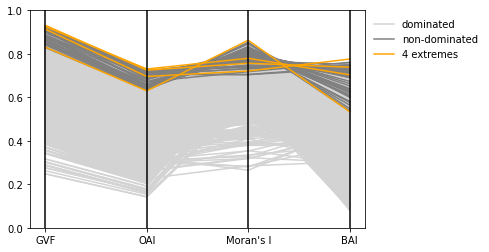

In [75]:
# from parallel_coordinates import pcpx

objective_names = [ 'GVF', 'OAI', 'Moran\'s I', 'BAI' ]
bounds = [[0, 1] for i in range(4)]

best_objs = [v[1] for v in extremes] 

nondominated_objs = [res[1] for res in nondominated]
dominated_objs = [res[1] for res in dominated]

colors = ['lightgrey']*len(dominated) + ['grey']*len(nondominated) + ['orange']*4
legend_labels = ['dominated']*len(dominated) + ['non-dominated']*len(nondominated) + ['4 extremes']*len(best_objs)

pcpx(dominated_objs + nondominated_objs + best_objs, 
     bounds=bounds, style=colors, labels=objective_names, 
     legend_labels=legend_labels, legend_loc=2, bbox_to_anchor=(1, 1))

plt.show()

## Mapping

Show good maps. Each of the four maps in the top row has one of the extreme values in the parallel coordinate plot. The ones in the second row are samples from the non-dominated maps (but none of them exhibits the extreme values).

We first draw the four maps with the extreme solutions.

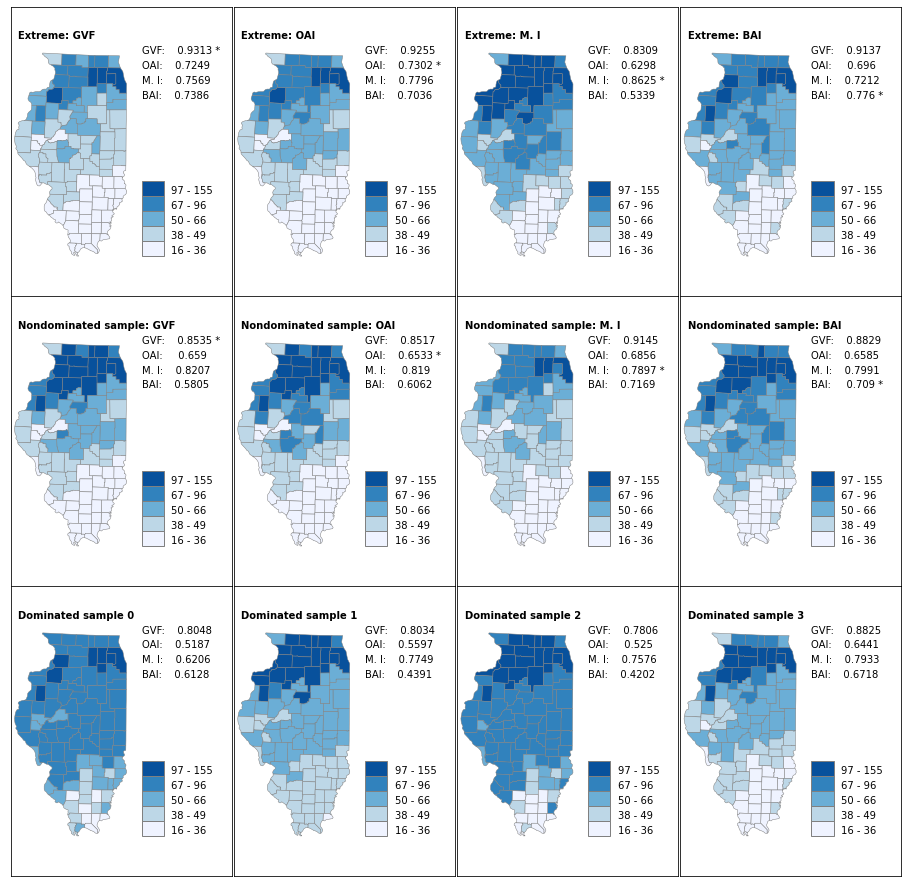

In [123]:
fig, ax2 = plt.subplots(3, 4, sharey=True, sharex=True)
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)
fig.set_figheight(16)
fig.set_figwidth(16)

colors = get_colorbrewer_specs('Blues', numclass)
objective_names = [ 'GVF', 'OAI', 'M. I', 'BAI' ]

box_w = (xmax-xmin)/5  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

for axes in ax2:
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

for j in range(4):
    ax = ax2[0, j]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect(1)
    # myintervals = allintervals[bests[j]]
    intervals = extremes[j][0]
    classes = [intervals.get_class(i) for i in all_values] 
    #vector = driver.Open(shpfname, 0)
    #layer = vector.GetLayer(0)
    draw_shape(shp, classes, colors, axis=ax)
    rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax, colors, ygap=label_ygap, edgecolor='grey', intervals=myintervals)
    objs = extremes[j][1]
    ax.text(xmin*1.1, ymax+box_h, 'Extreme: {}'.format(objective_names[j]), weight='bold')
    for i in range(4):
        ax.text(xmax*1.1, ymax-i*box_h, '{}:{:10.4} {}'.format(objective_names[i], objs[i], '*' if i==j else ''))

#     mark_make_label(xmin+1.0, ymin+1.0, ax, objs)
    
four_maps = random.sample(nondominated, 4)

for j in range(4):
    ax = ax2[1, j]
    ax.set_xlim(xmin*0.9, xmax*1.7)
    ax.set_ylim(ymin*0.97, ymax*1.03)
    ax.set_aspect(1)
    intervals = four_maps[j][0]
    classes = [intervals.get_class(i) for i in all_values] 
    draw_shape(shp, classes, colors, axis=ax)
    rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax, colors, ygap=label_ygap, edgecolor='grey', intervals=myintervals)
    objs = four_maps[j][1]
    ax.text(xmin*1.1, ymax+box_h, 'Nondominated sample: {}'.format(objective_names[j]), weight='bold')
    for i in range(4):
        ax.text(xmax*1.1, ymax-i*box_h, '{}:{:10.4} {}'.format(objective_names[i], objs[i], '*' if i==j else ''))

four_maps2 = random.sample(dominated, 4)

for j in range(4):
    ax = ax2[2, j]
    ax.set_xlim(xmin*0.9, xmax*1.7)
    ax.set_ylim(ymin*0.97, ymax*1.03)
    ax.set_aspect(1)
    intervals = four_maps2[j][0]
    classes = [intervals.get_class(i) for i in all_values] 
    draw_shape(shp, classes, colors, axis=ax)
    rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax, colors, ygap=label_ygap, edgecolor='grey', intervals=myintervals)
    objs = four_maps2[j][1]
    ax.text(xmin*1.1, ymax+box_h, 'Dominated sample {}'.format(j), weight='bold')
    for i in range(4):
        ax.text(xmax*1.1, ymax-i*box_h, '{}:{:10.4}'.format(objective_names[i], objs[i]))

plt.show()